In [1]:
import matplotlib.pylab as plt
import numpy as np

from environment import MsdSystem
from uclk import UclkAgent

In [2]:
na = 2
actions = np.linspace(-3, 3, na) # (na,)

env = MsdSystem()
T_simulation = 5.0
weight_mv = 0.0

In [3]:
def run_closed_loop_simulation(agent: UclkAgent, 
    env: MsdSystem, actions, T_simulation, y_initial):

    env.reset(y_initial=y_initial)
    while True:
        q = agent.predict_q(env.y) # (na,)
        u = actions[np.argmax(q)] # (,)    
        env.step(u)
        if env.t > T_simulation:
            break

In [4]:
def reward(S):
    # S: (...,nx)
    Position = S[...,0] # (...)
    Velocity = S[...,1] # (...)
    Error = np.abs(Position) + np.abs(Velocity) # (...)
    cost = Error[:,None] + weight_mv * np.abs(actions) 
    # (...,1) + (na) -> (...,na)
    Reward = -cost # (...,na)
    return Reward

In [5]:
def collect_training_data(N):

    nx = env.nx

    S0 = np.zeros((N, nx)) # (N, nx)
    A0 = np.random.randint(low=0, high=na, size=(N,)) # (N,)
    S1 = np.zeros((N, nx)) # (N, nx)
    for i in range(N):
        env.reset()
        S0[i,:] = env.y
        env.step(actions[A0[i]])            
        S1[i,:] = env.y # (nx,)

    return S0, A0, S1

In [6]:
def train(feat_map_params, training_params, S0, A0, S1):

    nx = env.nx

    agent = UclkAgent(nx=nx,na=na,**feat_map_params)
    
    S_tld = S0.copy() # (N, nx)
    R_tld = reward(S_tld) # (N, na)

    agent.fit(S0, A0, S1, S_tld, R_tld, **training_params)

    return agent

In [7]:
def evaluate_trained_agent(agent: UclkAgent, S0, A0, fig):    

    n_fig = 4
    for i, y_initial in enumerate([(1,0), (-1,0), (0,1), (0,-1)]):
        ax = fig.add_subplot(n_fig, 1, i+1)

        run_closed_loop_simulation(agent, env, 
            actions, T_simulation, y_initial=y_initial)
        P = np.stack(env.log["Position"], axis=0) # (*)
        V = np.stack(env.log["Velocity"], axis=0) # (*)
        F = np.stack(env.log["Force"], axis=0) # (*)
        T = np.stack(env.log["Time"], axis=0) # (*)

        ax.set_title("Initial state Pos = %.2f Vel = %.2f" % (P[0], V[0]))
        ax.plot(T, P, label = "Position")
        ax.plot(T, V, label = "Velocity")
        ax.plot(T, F, label = "Force")
        ax.set_ylim(-3,3)
        ax.legend()
        ax.grid()
    
    fig.tight_layout()
    return

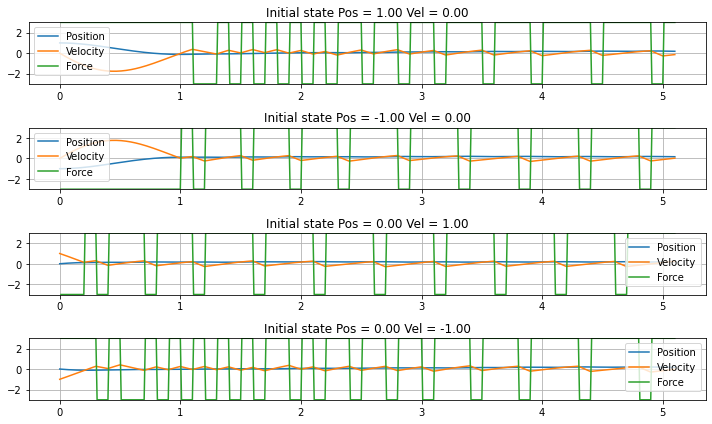

In [8]:
S0, A0, S1 = collect_training_data(N = 2**11)

training_params = dict(n_rounds=2, gamma = 0.9, n_itr = 2)
feat_map_params = dict(d=32, scale=1.0)

agent = train(feat_map_params, training_params, S0, A0, S1)
fig = plt.figure(figsize=[10, 6])
evaluate_trained_agent(agent, S0, A0, fig)